# Sentiment Analysis of Amazon's customer reviews

### Problem Statement : 
##### The task is to build models which can identify the sentiment (positive or negative) of each of the reviews contains in the dataset.

In [2]:
# Importing the General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

#Importing NLP libraries
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud

# Importing Modeling libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=12)
import pickle

from pylab import rcParams
import warnings
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 14,6
plt.style.use('ggplot')





In [3]:
# Importing the data
reviews = pd.read_csv('AmazonReviews.csv')

In [4]:
reviews.head()

,Unnamed: 0,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#### About the Data : 
Each review contains textual feedback along with a 1-to-5 star rating system (1 being least satisfied and 5 being most satisfied). In this way, the following attributes are available in the data:

1. **ProductId (categorical):** ID of the referenced product by the customer.
2. **UserId (categorical):** registered user ID.
3. **ProfileName (text):** registered user profile name.
4. **HelpfulnessNumerator (numerical):** number of users who found the review helpful.
5. **HelpfulnessDenominator (numerical):** Number of users who voted whether the review was helpful or not.
6. **Score (ordinal):** rating between 1 and 5.
7. **Time (numerical):** timestamp of the review.
8. **Summary (text):** brief summary of the review.
9. **Text (text):** text of the review.

Let's look at the distribution of number of words per review. We will do this by applying a lambda function that splits each complete review by spaces, which will give us the broad words:

In [5]:
reviews.isnull().sum()

Unnamed: 0                0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [6]:
reviews.drop('Unnamed: 0',axis=1,inplace=True)

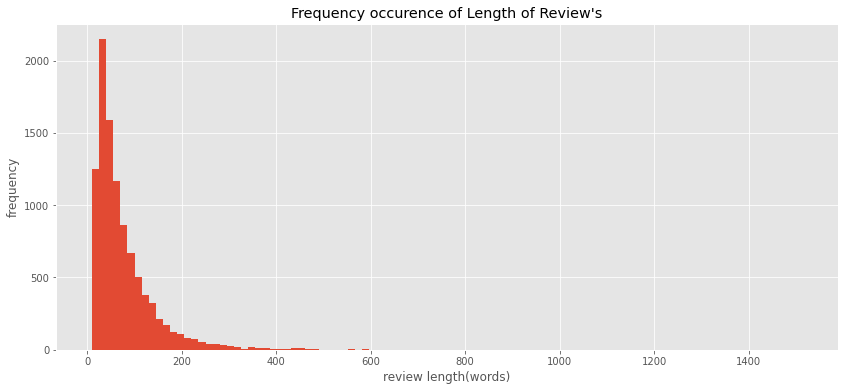

In [7]:
# Getting the number of words by splitting them by a space
words_per_review = reviews['Text'].apply(lambda x : len(x.split(" ")))
words_per_review.hist(bins=100)
plt.xlabel('review length(words)')
plt.ylabel('frequency')
plt.title("Frequency occurence of Length of Review's")
plt.show()

In [8]:
print('Average words:', words_per_review.mean())
print('Skewness:', words_per_review.skew())

Average words: 77.9028
Skewness: 4.612459483340116


On Average the user writes about 78 words and we can also see that the distribution is highly positive skewed

In [9]:
percent_val = 100 * reviews['Score'].value_counts()/len(reviews)
percent_val

5    61.83
4    14.33
1     9.32
3     8.62
2     5.90
Name: Score, dtype: float64

Text(0, 0.5, 'Percentage')

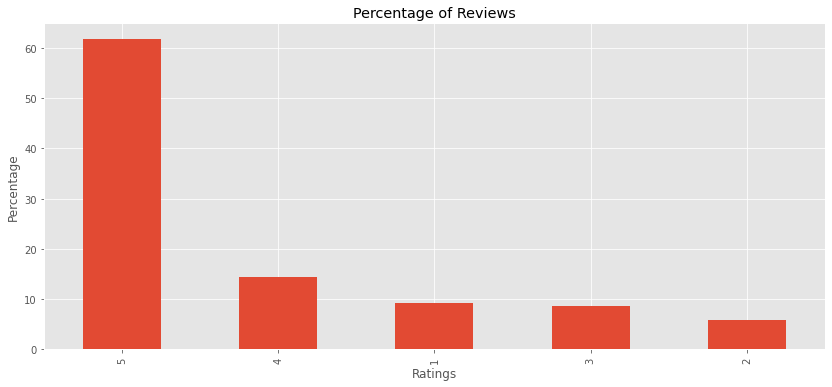

In [10]:
percent_val.plot.bar()
plt.title('Percentage of Reviews')
plt.xlabel('Ratings')
plt.ylabel('Percentage')

The distribution is quite skewed, with a giant number of 5s and very few 3s, 2s, and 1s.

### Text visualization using word clouds

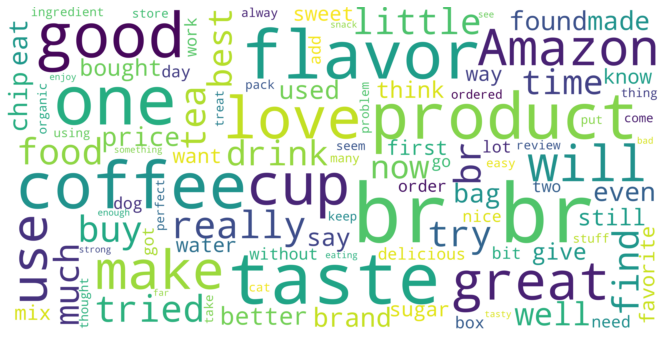

In [11]:
word_cloud_text = ''.join(reviews['Text'])
wordcloud = WordCloud(max_font_size=100,max_words=100,background_color='white',scale=10,width=800,height=400).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()


The word cloud indicates that many of the reviews talk about food-related things - coffee, flavor, food, taste, drink. We also see some positive words like good, love, best, as well as not desired ones such as br (line break), many (determiner) and something (adverb)

### Standardizing the ratings for sentiment analysis

For the purposes of sentiment analysis, we will convert all of the ratings into binary values using the follow rule:

Ratings of 4 or 5 will get mapped to 1 and will be related to positive reviews
Ratings of 1 or 2 will get mapped to 0 and will be related to negative reviews
Ratings of 3 will get removed since they will represent neutral reviews.

In [12]:
reviews.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [13]:
# Mapping Ratings
reviews['sentiment_rating'] = np.where(reviews['Score'] >3,1,0)

# Removing neutral reviews
reviews = reviews[reviews['Score']!=3]

# Printing the counts of each class
reviews['sentiment_rating'].value_counts()


1    7616
0    1522
Name: sentiment_rating, dtype: int64

### Handling of Imbalance class

In [14]:
count_class_0 , count_class_1 = reviews.sentiment_rating.value_counts()

reviews_class_0 = reviews[reviews['sentiment_rating']==0]
reviews_class_1 = reviews[reviews['sentiment_rating']==1]


In [15]:
reviews_class_0.shape

(1522, 10)

In [16]:
reviews_class_1.shape

(7616, 10)

In [17]:
count_class_0 , count_class_1

(7616, 1522)

In [18]:
sentiment_class_1_under = reviews_class_1.sample(count_class_1)
sentiment_class_1_under.shape

(1522, 10)

In [19]:
reviews_test_under = pd.concat([sentiment_class_1_under, reviews_class_0],axis=0)
reviews_test_under.shape

print('Under sampling')
print(reviews_test_under['sentiment_rating'].value_counts())

Under sampling
0    1522
1    1522
Name: sentiment_rating, dtype: int64


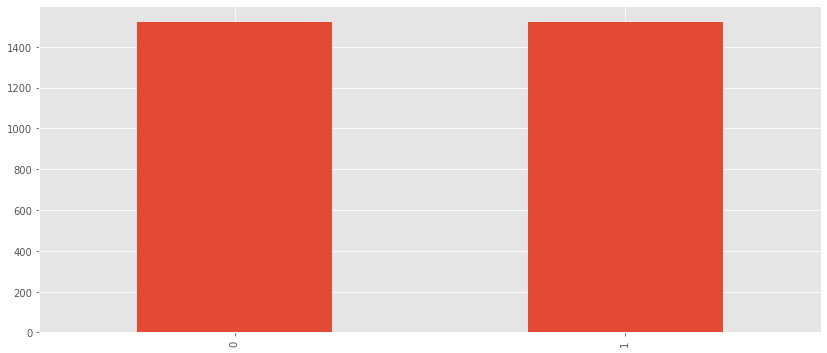

In [20]:
reviews_test_under.sentiment_rating.value_counts().plot.bar()
plt.show()

As we can see here now the class is balanced 

### Pre-processing
Text preprocessing and normalization is crucial before building a proper NLP model. Some of the important steps are:

1. Converting words to lower/upper case
2. Removing special characters
3. Removing stopwords and high/low-frequency words
4. Stemming/lemmatization

#####  Converting words to lower/upper case
Let's start by converting all of the words into a consistent case format, say lowercase:

In [21]:
reviews_test_under['reviews_text_new'] = reviews_test_under['Text'].str.lower()

In [22]:
# For reviews not converted to lower case
token_lists = [word_tokenize(each) for each in reviews_test_under['Text']]
tokens = [item for sublist in token_lists for item in sublist ]
print("Number of unique tokens then: ",len(set(tokens)))

# For reviews converted to lower case
token_lists_lower = [word_tokenize(each) for each in reviews_test_under['reviews_text_new']]
tokens_lower = [item for sublist in token_lists_lower for item in sublist]
print("Number of unique tokens now: ",len(set(tokens_lower)))




Number of unique tokens then:  15960
Number of unique tokens now:  13119


The number of tokens has gone down by ~18% just from normalizing the corpus.

### Removing special characters

In [23]:
### Selecting non alpha numeric charactes that are not spaces
spl_chars = reviews_test_under['reviews_text_new'].apply(lambda review: 
                                                     [char for char in list(review) if not char.isalnum() and char != ' '])

## Getting list of list into a single list
flat_list = [item for sublist in spl_chars for item in sublist]

## Unique special characters
set(flat_list)

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 ']',
 '^',
 '_',
 '`',
 '}',
 '~',
 '®'}

 Remove these special characters from the reviews by applying a regular expression:

In [24]:
review_backup = reviews_test_under['reviews_text_new'].copy()
reviews_test_under['reviews_text_new'] = reviews_test_under['reviews_text_new'].str.replace(r'[^A-Za-z0-9 ]+', ' ')

The number of unique tokens has dropped further

In [25]:
token_lists = [word_tokenize(each) for each in reviews['Text']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens then: ",len(set(tokens)))

token_lists = [word_tokenize(each) for each in reviews_test_under['reviews_text_new']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens now: ",len(set(tokens)))

Number of unique tokens then:  27509
Number of unique tokens now:  11234


### Stopwords and high/low frequency words

stopwords naturally occur very frequently in the English language without adding any context specific insights. It makes sense to remove them.

In [26]:
from nltk.corpus import stopwords

print(stopwords.fileids())

['arabic', 'azerbaijani', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']


Let's now review the list of English stopwords:

In [27]:
noise_words = []
eng_stop_words = stopwords.words('english')
eng_stop_words


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [30]:
stop_words = set(eng_stop_words)
without_stop_words = []
stopword = []
sentence = reviews_test_under['reviews_text_new'][1]
words = nltk.word_tokenize(sentence)

for word in words:
    if word in stop_words:
        stopword.append(word)
    else:
        without_stop_words.append(word)

print('--Original sentence-- \n',sentence)
print('--Stopwords in the sentence--\n',stopword)
print('--Non stopwords in the sentence--\n',without_stop_words)


--Original sentence-- 
 product arrived labeled as jumbo salted peanuts the peanuts were actually small sized unsalted  not sure if this was an error or if the vendor intended to represent the product as  jumbo 
--Stopwords in the sentence--
 ['as', 'the', 'were', 'not', 'if', 'this', 'was', 'an', 'or', 'if', 'the', 'to', 'the', 'as']
--Non stopwords in the sentence--
 ['product', 'arrived', 'labeled', 'jumbo', 'salted', 'peanuts', 'peanuts', 'actually', 'small', 'sized', 'unsalted', 'sure', 'error', 'vendor', 'intended', 'represent', 'product', 'jumbo']


Now, we have to omit these stopwords from our reviews:

In [31]:
def stopword_removal(stop_words,sentence):
    return [word for word in nltk.word_tokenize(sentence) if word not in stop_words]

reviews_test_under['reviews_text_nonstop'] = reviews_test_under['reviews_text_new'].apply(lambda row: stopword_removal(stop_words,row))
reviews_test_under[['reviews_text_new','reviews_text_nonstop']]

,reviews_text_new,reviews_text_nonstop
3245,to everyone worried about not getting a full c...,"[everyone, worried, getting, full, cup, run, m..."
6327,with jack links buying king b it looks like t...,"[jack, links, buying, king, b, looks, like, re..."
1589,while on a family camping trip with josh our 8...,"[family, camping, trip, josh, 8yr, old, golden..."
5865,i love the walnut oil it came in cans which i...,"[love, walnut, oil, came, cans, like, lot, har..."
4136,this product works just as advertised guitar ...,"[product, works, advertised, guitar, center, t..."
...,...,...
9976,this was the first time i tried purchasing a f...,"[first, time, tried, purchasing, food, product..."
9977,i was surprised by the number of 5 star review...,"[surprised, number, 5, star, reviews, product,..."
9985,you think you re doing something good for your...,"[think, something, good, kid, invest, little, ..."
9986,2 0 out of 5 stars read this article first au...,"[2, 0, 5, stars, read, article, first, august,..."


### Building a machine learning model
Now we have cleaned-up versions of two very important pieces of data – the actual review text and its corresponding sentiment rating:

In [32]:
reviews_test_under[['Text','Score','sentiment_rating']].head(5)

,Text,Score,sentiment_rating
3245,To everyone worried about not getting a full c...,4,1
6327,"With Jack Links buying King B, it looks like t...",4,1
1589,While on a family camping trip with Josh our 8...,5,1
5865,I love the walnut oil. It came in cans which i...,5,1
4136,This product works just as advertised!! Guitar...,5,1


#### Bag-of-words
The bag-of-words procedure falls under a broader category of techniques known as count-based representations. These are techniques to analyze documents by indicating how frequently certain types of structures occur throughout.

Let's create a word-document co-occurrence matrix for our set of reviews using the CountVectorizer class that automatically accounts for certain preprocessing steps like removing stopwords, stemming, creating n-grams, and word tokenization:

In [33]:
# creating a word-document matrix
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
X = vec.fit_transform(reviews_test_under['reviews_text_new'])
df = pd.DataFrame(X.toarray(),columns=vec.get_feature_names())
df.head()



,00,000,03,0303,0472066978,05,06,07,0738551856,09,...,zipper,zippy,ziwipeak,zola,zon,zoom,zucchini,zuke,zukes,zupas
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's use this to create a bag of words from the reviews, excluding the noise words we identified earlier:

In [34]:
# Creating a python object of the class CountVectorizer
bow_counts = CountVectorizer(tokenizer=word_tokenize,stop_words=noise_words,ngram_range=(1,4))

bow_data = bow_counts.fit_transform(reviews_test_under['reviews_text_new'])

In [35]:
bow_data

<3044x516407 sparse matrix of type '<class 'numpy.int64'>'
	with 899787 stored elements in Compressed Sparse Row format>

In [36]:
# Creating a pickle file for the CountVectorizer
pickle.dump(bow_counts, open('countvector.pkl', 'wb'))

Once the bag of words is prepared, now we can divide the dataset into training and test sets

In [37]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(bow_data, # Features
                                                                                       reviews_test_under['sentiment_rating'], # Target variable
test_size = 0.2, 
random_state = 0) 

In [38]:
y_test_bow.value_counts()/y_test_bow.shape[0]

1    0.543514
0    0.456486
Name: sentiment_rating, dtype: float64

In [39]:
X_test_bow

<609x516407 sparse matrix of type '<class 'numpy.int64'>'
	with 179560 stored elements in Compressed Sparse Row format>

### Applying logistic regression
Let's train the model on our training data and run the resulting model on our test data

In [40]:
# Defining and training the model
lr_model_all_new = LogisticRegression(max_iter = 200)
lr_model_all_new.fit(X_train_bow, y_train_bow)

# Predicting the results
test_pred_lr_all = lr_model_all_new.predict(X_test_bow)

print("F1 score: ", f1_score(y_test_bow,test_pred_lr_all))
print('The accuracy of the Logistic Regression is',accuracy_score(test_pred_lr_all,y_test_bow)*100)
cm = confusion_matrix(y_test_bow, test_pred_lr_all)
cm

F1 score:  0.8267477203647416
The accuracy of the Logistic Regression is 81.2807881773399


array([[223,  55],
       [ 59, 272]], dtype=int64)

### Applying Naive Bayes

In [41]:

#MultiGaussianNB
mnb = MultinomialNB(alpha=10)
cv = cross_val_score(mnb,X_train_bow, y_train_bow,cv=kfold)
print(cv)
print(cv.mean()*100)
mnb.fit(X_train_bow, y_train_bow)
y_pred_mnb=mnb.predict(X_test_bow)
print('The accuracy of the Naive Bayes is', accuracy_score(y_pred_mnb,y_test_bow)*100)
cm=confusion_matrix(y_test_bow, y_pred_mnb)
print(cm)

[0.73399015 0.66995074 0.65024631 0.66995074 0.65024631 0.66995074
 0.71428571 0.67487685 0.66995074 0.69950739 0.70935961 0.69306931]
68.37820481555545
The accuracy of the Naive Bayes is 65.1888341543514
[[277   1]
 [211 120]]


In [42]:
# get all the n-gram feature names
lr_weights = pd.DataFrame(list(zip(bow_counts.get_feature_names(), 
                                   lr_model_all_new.coef_[0])), # get the logistic regression coefficients
                          columns= ['words','weights'])

# top-15 more important features for positive reviews
lr_weights.sort_values(['weights'], ascending = False)[:15] 

,words,weights
181846,great,1.291610
260881,love,0.894548
125379,delicious,0.833106
178167,good,0.754918
70116,best,0.727667
417013,the best,0.652815
331008,perfect,0.614291
153843,find,0.587886
379639,smooth,0.562129
288776,nice,0.537634


In [43]:
# top-15 more important features for negative reviews
lr_weights.sort_values(['weights'], ascending = False)[-15:]

,words,weights
488546,waste,-0.399549
130170,disappointing,-0.406508
508525,would,-0.409239
489839,way,-0.423222
452000,thought,-0.437895
127264,did,-0.441750
306678,off,-0.442699
59099,awful,-0.457616
493684,were,-0.473760
491777,weak,-0.516592


### TF-IDF model
It evaluates how important a word is to a document within a large collection of documents (i.e. corpus). The importance increases proportionally based on the number of times a word appears in the document but is offset by the frequency of the word in the corpus.

The TF-IDF weight is the product of two terms. The first computes the normalized Term Frequency (TF); i.e. the number of times a word appears in a document divided by the total number of words in that document. The second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

### Creating a python object of the class CountVectorizer
tfidf_counts = TfidfVectorizer(tokenizer= word_tokenize, # type of tokenization
                               stop_words=noise_words, # List of stopwords
                               ngram_range=(1,4)) # number of n-grams

tfidf_data = tfidf_counts.fit_transform(reviews_test_under['reviews_text_new'])

In [45]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_data,
                        reviews_test_under['sentiment_rating'],test_size = 0.2,random_state = 0)

### Applying logistic regression to TF-IDF features

In [46]:
### Setting up the model class
lr_model_tf_idf = LogisticRegression()

## Training the model 
lr_model_tf_idf.fit(X_train_tfidf,y_train_tfidf)

## Prediciting the results
test_pred_lr_all = lr_model_tf_idf.predict(X_test_tfidf)

## Evaluating the model
print("F1 score: ",f1_score(y_test_bow, test_pred_lr_all))

F1 score:  0.8069620253164557


Here we have decresed  our F1 score value with TF-IDF as compared to the bag-of-words approach. 
The best Model in terms of accuracy and F1 score is logistic Regression along with bag of words approach

In [47]:
# Saving the Model
filename = 'Logistic_Reg_model.pkl'
pickle.dump(lr_model_all_new,open(filename,'wb'))